In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
df = pd.read_excel('DATA FILE 334 (2).xlsx')  # Adjust the path to your file

# Ensure all column names are treated as strings (important if there are unnamed/numerical columns)
df.columns = df.columns.map(str)

In [3]:
df.columns

Index(['Part ID', 'Planning Leadtime', 'Order Policy', 'Order Point',
       'Safety Stock Qty', 'Fixed Order Qty', 'Days Of Supply',
       'Minimum Order Qty', 'Maximum Order Qty', 'Multiple Order Qty', 'Fab',
       'Pur', 'Stocked', 'Detail Only', 'Purc Lt', 'Abc Code',
       'Inventory Locked', 'Inventory$', 'Unit Material Cost',
       'Annual Usage Qty', 'Prev Yr Usage', 'Roll Ann Usage', 'Qty On Hand',
       'Qty Available Mrp', 'TotAlloc', 'Coeff_Code', 'Stock Um',
       'Def Orig Country', 'Primary Whs Id', 'Primary Loc Id',
       'Annual Usage Value', '2666342.46838269', 'Profit %',
       'Cummulatove Profit %', 'Jan (2018)', 'Feb (2018)', 'Mar (2018)',
       'Apr (2018)', 'May (2018)', 'June (2018)', 'July (2018)', 'Aug (2018)',
       'Sep (2018)', 'Oct (2018)', 'Nov (2018)', 'Dec (2018)', 'Jan (2019)',
       'Feb (2019)', 'Mar (2019)', 'Apr (2019)', 'May (2019)', 'June (2019)',
       'July (2019)', 'Aug (2019)', 'Sep (2019)', 'Oct (2019)', 'Nov (2019)',
       'De

In [4]:
# Company's Orginal Classification
# Calculate the total number of products
df.replace('Spiker', 'Stranger', inplace=True)
original_counts = df['Coeff_Code'].value_counts()
total_products = len(df)

# Calculate the number of products in each category
num_repeaters = len(df[df['Coeff_Code'] == 'Repeater'])
num_runners = len(df[df['Coeff_Code'] == 'Runner'])
num_strangers = len(df[df['Coeff_Code'].isin(['Spiker', 'Stranger'])])

# Calculate the percentage of products in each category
percentage_repeaters_old = (num_repeaters / total_products) * 100
percentage_runners_old = (num_runners / total_products) * 100
percentage_strangers_old = (num_strangers / total_products) * 100

# Print out the percentages
print(f"Percentage of Repeaters: {percentage_repeaters_old:.2f}%")
print(f"Percentage of Runners: {percentage_runners_old:.2f}%")
print(f"Percentage of Strangers: {percentage_strangers_old:.2f}%")

Percentage of Repeaters: 5.95%
Percentage of Runners: 10.60%
Percentage of Strangers: 83.45%


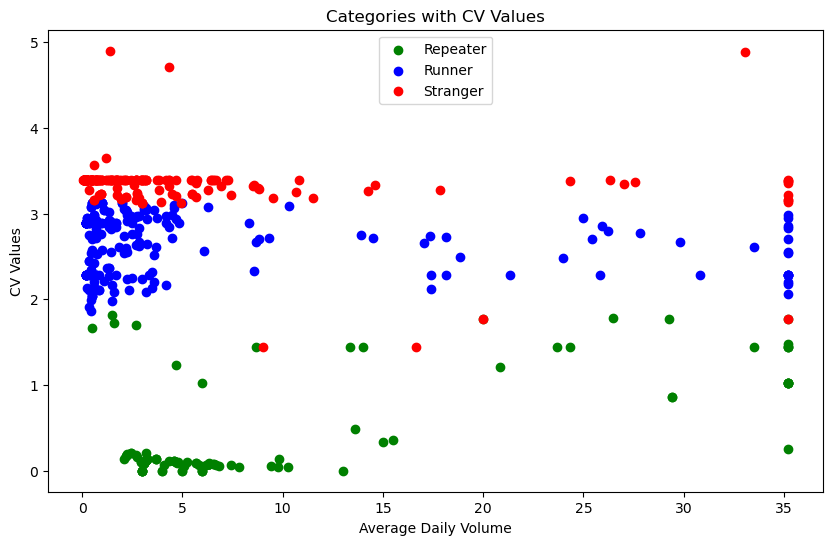

In [5]:
# List of columns that represent monthly demand data
# Adjust these column names to match your actual monthly demand columns
monthly_demand_columns = [col for col in df.columns if col.startswith('Jan') or col.startswith('Feb') or col.startswith('Mar') 
                          or col.startswith('Apr') or col.startswith('May') or col.startswith('Jun') 
                          or col.startswith('Jul') or col.startswith('Aug') or col.startswith('Sep') 
                          or col.startswith('Oct') or col.startswith('Nov') or col.startswith('Dec')]

df[monthly_demand_columns] = df[monthly_demand_columns].fillna(0)

# Calculate mean, standard deviation, and CV for each product across its monthly demand
df['mean_demand'] = df[monthly_demand_columns].mean(axis=1)
df['std_demand'] = df[monthly_demand_columns].std(axis=1)
df['cv_demand'] = df['std_demand'] / df['mean_demand']

# Count number of zeros in each row
df['zero_count'] = (df[monthly_demand_columns] == 0).sum(axis=1)

# Mark as 'Stranger' if more than 16 months of zeros
df['category'] = np.where(df['zero_count'] > 16, 'Stranger', '')

# Aggregate demand data to identify seasonal patterns
monthly_demand_means = df[monthly_demand_columns].mean()

# Calculate coefficient of variation (CV) for each month
monthly_demand_cv = df[monthly_demand_columns].std() / df[monthly_demand_columns].mean()

# Identify peak demand months
peak_demand_months = monthly_demand_means.nlargest(3).index.tolist()

# Define seasonality feature based on peak demand months
df['seasonality'] = np.where(df[peak_demand_months].sum(axis=1) > 0, 'Seasonal', 'Non-Seasonal')

# Adjust categorization logic to incorporate the 'seasonality' feature
cv_low_threshold = df['cv_demand'].quantile(0.20)
cv_high_threshold = df['cv_demand'].quantile(0.60)

conditions = [
    (df['cv_demand'] <= cv_low_threshold) & (df['seasonality'] == 'Seasonal'),
    (df['cv_demand'] > cv_low_threshold) & (df['cv_demand'] <= cv_high_threshold),
    (df['cv_demand'] > cv_high_threshold)
]
choices = ['Repeater', 'Runner', 'Stranger']
df['category'] = np.select(conditions, choices, default='Stranger')

# Capping cv_demand values at a certain threshold
cap_threshold = np.percentile(df['mean_demand'], 95)  # Example: cap at the 95th percentile
df['mean_demand_capped'] = df['mean_demand'].clip(upper=cap_threshold)

# Plotting
colors = {'Repeater': 'green', 'Runner': 'blue', 'Stranger': 'red'}
plt.figure(figsize=(10, 6))
for category, group in df.groupby('category'):
    plt.scatter(group['mean_demand_capped'], group['cv_demand'], label=category, color=colors[category])

plt.xlabel('Average Daily Volume')
plt.ylabel('CV Values')
plt.title('Categories with CV Values')
plt.legend()
plt.show()


In [6]:
# Company's Altered Classification
# Calculate the total number of products
new_counts = df['category'].value_counts()
total_products = len(df)

# Calculate the number of products in each category
num_repeaters = len(df[df['category'] == 'Repeater'])
num_runners = len(df[df['category'] == 'Runner'])
num_strangers = len(df[df['category'] == 'Stranger'])

# Calculate the percentage of products in each category
percentage_repeaters = (num_repeaters / total_products) * 100
percentage_runners = (num_runners / total_products) * 100
percentage_strangers = (num_strangers / total_products) * 100

# Print out the percentages
print(f"Percentage of Repeaters: {percentage_repeaters:.2f}%")
print(f"Percentage of Runners: {percentage_runners:.2f}%")
print(f"Percentage of Strangers: {percentage_strangers:.2f}%")

Percentage of Repeaters: 15.24%
Percentage of Runners: 31.49%
Percentage of Strangers: 53.27%


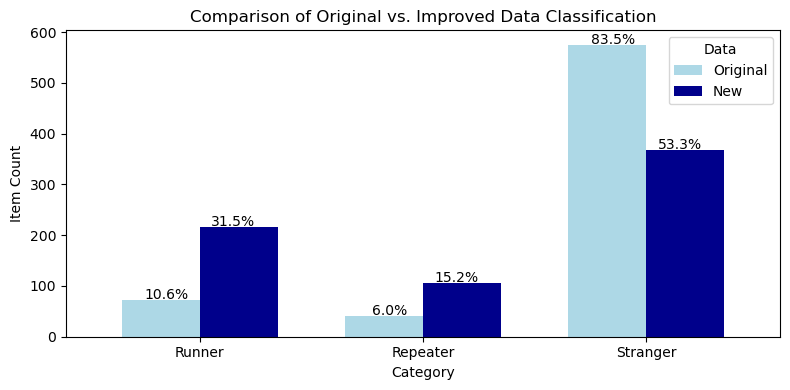

In [7]:
comparison_df = pd.DataFrame({
    'Runner': [original_counts['Runner'], new_counts['Runner']],
    'Repeater': [original_counts['Repeater'], new_counts['Repeater']],
    'Stranger': [original_counts['Stranger'], new_counts['Stranger']]
}, index=['Original', 'New'])

# Re-order the columns if necessary
comparison_df = comparison_df[['Runner', 'Repeater', 'Stranger']]

# Plotting the comparison as a bar graph
colors = ['#ADD8E6', '#00008B'] 
comparison_df.T.plot(kind='bar', color=colors, figsize=(8, 4), width=0.7)
plt.xlabel('Category')
plt.ylabel('Item Count')
plt.title('Comparison of Original vs. Improved Data Classification')
plt.xticks(rotation=0)
plt.legend(title='Data')

# Annotations
for i, row in enumerate(comparison_df.values):
    for j, value in enumerate(row):
        percentage = [percentage_runners_old, percentage_repeaters_old, percentage_strangers_old,
                      percentage_runners, percentage_repeaters, percentage_strangers][i*3+j]
        plt.text(j - 0.15 + i*0.3, value + 2, f'{percentage:.1f}%', ha='center')

plt.tight_layout()
plt.show()